# TP IENM1 : Normales, variabilité et extrèmes

## Plan du TP

- I. Autour de python
- II. Données
- III. Normales
- IV. Densités climatiques
- V. Extrêmes
- Conclusion
- VI. Quelques bonus

## I. Autour de python
- Ce TP se déroule en python,
- La première partie consistera à vérifier que les packages necessaires sont bien installés
- Dans les cellules de code, le symbole `#` permet de faire des commentaires qui seront ignorés par python
- Toutes les fonctions "difficiles" sont déja implémenté, et je propose un exemple qui répond partiellement aux questions, inspirez vous en!
- Vous pouvez acceder à la documentation d'une fonction en tapant dans un terminal `help(ma_fonction)`, comme dans la cellule suivante

In [2]:
help(len)

Help on built-in function len in module builtins:

len(obj, /)
    Return the number of items in a container.



### I.1 Packages
La cellule suivante contient les librairies à charger, ne pas la modifier.

***Si l'execution de cette cellule ne fonctionne pas:***
- Installer les packages manquant en tapant dans un terminal: `pip3 install --user package`,
- Redemarrer le noyau dans le menu ci dessus.

In [1]:
## Packages système
##=================
import sys,os              ## Permet d'acceder à des fonctions du système
import pickle as pk        ## Sauvegarde et chargement des objets python

## Packages scientifique
##======================
import numpy as np         ## Donne les 'np.array': vecteurs, matrices ou matrices multi-dimensionelle (tenseur)
import scipy.stats as sc   ## Fonctions statistiques
import scipy.linalg as scl ## Fonctions avancées en algèbre linéaire
import xarray as xr        ## Dataframe multi-dimensionel, permet d'indexer facilement les données


## Packages pour les figures
##==========================
%matplotlib inline
import matplotlib as mpl           ## Configuration de matplotlib
import matplotlib.pyplot as plt    ## Contient les fonctions pour les figures

## Malheureusement cartopy n'est pas installable à l'ENM, vous pourrez essayer ailleurs
#import cartopy.crs as ccrs         ## Contient les fonctions pour afficher des cartes
#import cartopy.feature as cf       ## Contient les fonctions pour ajouter des éléments sur les cartes (continent...)

### II.2 Quelques fonctions utiles
Dans cette section je donne quelques fonctions à ne pas modifier qui seront utilisées plus loin

In [2]:
def _add_fig_labels( dX , axes ):
	"""
	Fonctions générique pour les labels des figures
	"""
	day_per_month = np.array( [0,31,28,31,30,31,30,31,31,30,31,30] )
	xticks = np.cumsum(day_per_month)
	xticks_labels = ["J","F","M","A","M","J","J","A","S","O","N","D"]
	xticks_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
	
	lylim = np.array( [ ax.get_ylim() for ax in axes] )
	ylim = (lylim[:,0].min(),lylim[:,1].max())
	for i,c in enumerate(dX.location):
		axes[i].set_title( "{}".format(str(c.values)) )
		axes[i].set_ylabel( "Tm")
		axes[i].set_xticks(xticks)
		axes[i].set_xticklabels(xticks_labels)
		axes[i].set_ylim(ylim)
	return axes

In [3]:
def _fig_normale( normale , **kwargs ):
	fig = plt.figure( figsize = (12,8) )
	axes = [fig.add_subplot(2,2,i+1) for i in range(4)]
	
	## Pass normale into list
	if type(normale) is not list:
		normale = [normale]
	n_normale = len(normale)
	
	## Define labels
	if kwargs.get("label_normale") is not None:
		label_normale = kwargs["label_normale"]
		if type(label_normale) is not list:
			label_normale = [label_normale]
	else:
		label_normale = [ "Normale {}".format(i) for i in range(len(normale)) ]
	
	## Define colors
	if kwargs.get("color_normale") is not None:
		color_normale = kwargs["color_normale"]
		if type(color_normale) is not list:
			color_normale = [color_normale]
	else:
		color_normale = [ c for c in plt.cm.hsv( np.linspace( 0.1 , 0.9 , n_normale ) ) ]
	
	if kwargs.get("loc_legend") is not None:
		loc_legend = kwargs.get("loc_legend")
	else:
		loc_legend = "lower center"
	
	for j,c in enumerate(normale[0].location):
		for i in range(n_normale):
			axes[j].plot( normale[i].loc[:,c] , color = color_normale[i] , label = label_normale[i] )
		axes[j].legend( loc = loc_legend )
	
	
	return fig,axes,normale

In [4]:
def _moving_average( X , axis , size_box , kernel = "uniform" , **kwargs ):
	"""
	Implémentation du lissage par noyau, ne pas modifier
	"""
	## Kernel
	if kernel == "gauss":
		scale = kwargs.get("scale") if kwargs.get("scale") is not None else 1
		x = np.linspace( -3 , 3 , size_box )
		k = np.exp(-x**2/scale**2)
		k /= np.sum(k)
	else: ## Uniform
		k = np.ones(size_box) / size_box
	
	## 1D function
	def _moving_average( X ):
		Xc = np.hstack( (X,X,X) )
		Xcs = np.convolve( Xc , k , mode = "same" )
		return Xcs[X.size:(2*X.size)]
	
	return np.apply_along_axis( _moving_average , axis = axis , arr = X )

In [5]:
def _fig_histogram( ldX , labels , dT , density , alpha = 0.5 ):
	## ldX into list
	if type(ldX) is not list: ldX = [ldX]
	
	## Labels
	if labels is None: labels = ["Dataset {}".format(i) for i in range(len(ldX)) ]
	elif type(labels) is not list : labels = [labels]
	
	## Find Tm interval
	Tmin = min( [float(dX.min()) for dX in ldX ] )
	Tmax = max( [float(dX.max()) for dX in ldX ] )
	Tm = np.arange( round(Tmin) - 1 , round(Tmax) + 1 , dT , dtype = np.float )
	
	
	## Figure
	fig    = plt.figure( figsize = (12,8) )
	axes   = [ fig.add_subplot(2,2,i+1) for i in range(4) ]
	colors = [ c for c in plt.cm.hsv(np.linspace(0.1,0.9,len(ldX))) ]
	
	ymax   = 0
	for i,l in enumerate(ldX[0].location):
		for j,dX in enumerate(ldX):
			axes[i].hist( dX.loc[:,l] , bins = Tm , color = colors[j] , alpha = alpha , label = labels[j] , density = density )
		axes[i].legend()
		axes[i].set_xlabel("Tm")
		axes[i].set_ylabel("Nombres d'occurence")
		axes[i].set_title("{}".format(str(l.values)))
		ymax = max( ymax , axes[i].get_ylim()[1] )
	
	for ax in axes:
		ax.set_ylim( (0,ymax) )
	
	return fig,axes,Tm,ldX,colors

## II. Données
### II.1 Chargement et format

In [6]:
dX = pk.load( open( "data/EOBS_tg.pk" , "rb" ) )


Dans ce TP quatre séries temporelle du 01/01/1950 au 31/07/2019 extraites du jeu de donnée [E-OBS](http://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php) seront utilisées:
- Température moyenne à Brest
- Température moyenne à Marseille
- Température moyenne à Briançon
- Température moyenne sur la France

Elles sont stockées dans la variable `dX`, qui est une variable du type *xarray.DataArray*. C'est une matrice de taille 25550x4, où chaque colonne est une des séries précédentes. L'axe du temps a été modifié de la manière suivante:

- Les 29 Février ont été supprimé (No Leap en Anglais), pour n'avoir que des années de 365 jours,
- Les séries ont été complétés du 01/08/2019 jusqu'au 31/12/2019 par des NaN (Not a Number), pour que la taille de la matrice soit un multiple de 365,

Les valeurs de la séries sont accessibles de la manière suivante:
- Soit en tapant `dX[i,j]` pour accéder à la i-ème date de la j-ième série,
- Soit en tapant par exemple `dX.loc[:,"France"]` pour acceder à toute la série de la France.

Un description sommaire de la variable `dX` peut être affiché avec un `print` comme dans l'exemple suivant:


In [7]:
print(dX)

<xarray.DataArray (time: 25550, location: 4)>
array([[ 1.4 ,  6.48,  6.69,  0.21],
       [ 1.16,  5.85,  4.57, -1.29],
       [ 4.17,  9.63,  6.62, -4.07],
       ...,
       [  nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan]])
Coordinates:
  * time      (time) object 1950-01-01 00:00:00 ... 2019-12-31 00:00:00
  * location  (location) <U9 'France' 'Brest' 'Marseille' 'Briancon'


### II.2 Sur une carte

Le code suivant permet d'afficher sur une carte centrée sur la France les coordonnées des 3 villes du jeu de données. La zone colorée représente ce qui est appelée "France" dans la série temporelle. La moyenne est faites sur cette zone, sachant que les mers/océans ont été ignoré.

In [8]:
## Ne marche pas à l'ENM vu que cartopy ne peut pas être installé, dommage
if False:
	lat = np.arange( 42 , 51.1 , 0.1 ) ## Latitudes, par 0.1deg
	lon = np.arange( -5 ,  8.1 , 0.1 ) ## Longitudes, par 0.1deg
	central_lat = np.median(lat)       ## Pour centrer la figure sur cette latitude
	central_lon = np.median(lon)       ## Pour centrer la figure sur cette longitude
	lats,lons = np.meshgrid(lat,lon)   ## Transforme les vecteurs lat/lon en deux grilles
	data = np.outer(lat,lon)           ## Fausse donnée pour l'affichage
	
	## Cette zone récupère les limites des pays/continents/océans
	f_country = cf.NaturalEarthFeature( "cultural" , "admin_0_boundary_lines_land" , "50m" ) 
	f_land    = cf.NaturalEarthFeature( "physical" , "land"  , "50m" )
	f_ocean   = cf.NaturalEarthFeature( "physical" , "ocean" , "50m" )
	cmap      = plt.cm.inferno ## Couleur de la zone "France"
	
	coord_cities = np.array( [ [-4.5,48.4], [5.3,43.5], [6.5,45] ] ) ## Coordonnées des villes
	name_cities  = ["Brest","Marseille","Briancon"]                  ## Noms des villes
	
	## Création d'une figure vide
	fig = plt.figure( figsize = (7,7) )
	
	## Ajout d'un "axe", i.e. des coordonnées pour faire le plot, le mot clé "projection"
	## permet de reprojeter un repère orthographique sur une figure 2D
	ax = fig.add_subplot( 1 , 1 , 1 , projection = ccrs.Orthographic( central_lon , central_lat ) ) 
	
	## Affichage de la France, les coordonnées "lon/lat" sont dans la projection qu'on appelle "PlateCarree" (défaut),
	## Le mot clé transform permet à python de les ramener au repère de la figure
	ax.pcolormesh( lons , lats , data.T , transform = ccrs.PlateCarree() , cmap = cmap , alpha = 0.4 , zorder = 2 )
	
	## Ajout des 3 points
	ax.scatter( coord_cities[:,0] , coord_cities[:,1] , transform = ccrs.PlateCarree() , color = "red" , s = 100 )
	
	## Boucle for pour les labels
	for i in range(3):
		ax.text( coord_cities[i,0] + 0.1 , coord_cities[i,1] + 0.1 , name_cities[i] , transform = ccrs.PlateCarree() , fontsize = 15 )
	
	## Et finalement on ajoute les pays/continents/océans
	ax.add_feature( f_country , zorder = 1 , edgecolor = "black" , facecolor = "none")
	ax.add_feature( f_land    , zorder = 0 , edgecolor = "black" , facecolor = "wheat" )
	ax.add_feature( f_ocean   , zorder = 0 , edgecolor = "black" , facecolor = "cornflowerblue" )
	
	ax.gridlines()
	#ax.set_global() ## Permet de "dé-zoomer" pour voir la Terre entière, vous pouvez essayer
	plt.show() ## On affiche la figure

### II.3 Affichage des séries
La cellule suivante contient une fonction qui permet d'afficher les séries pour une année en particulier.

In [9]:
def fig_time_series( dX , years ):
	"""
	Cette fonction affiche les 4 séries temporelle de dX aux années de la list years
	
	Arguments
	---------
	dX : xarray.DataArray
		La variable dX
	years : entier ou liste d'entier
		Les annnées à afficher
	
	Return
	------
	fig  : Une figure matplotlib
	axes : Une liste des axes où ont été ploté les données
	
	Exemples
	--------
	fig,axes = fig_time_series( dX , 1963 )
	plt.show()
	fig,axes = fig_time_series( dX , [1963,1988] )
	plt.show()
	"""
	if type(years) is not list:
		years = [years]
	fig = plt.figure( figsize = (12,8) ) ## Figure vide
	axes = [fig.add_subplot(2,2,i+1) for i in range(4)] ## 4 sous figures
	
	colors = [ c for c in plt.cm.hsv(np.linspace(0.1,0.9,len(years))) ] ## Une liste de couleurs
	kwargs = { "linestyle" : "" , "marker" : "." , "alpha" : 0.8} ## Arguments supplémentaires fixes
	
	for j,c in enumerate(dX.location): ## On boucle sur les time series
		for i,year in enumerate(years): ## On boucle sur les années
			dXy = dX.sel({"time":str(year)}).loc[:,c] ## On extrait l'année
			axes[j].plot( dXy , label = str(year) , color = colors[i] , **kwargs ) ## On affiche
		axes[j].legend( loc = "lower center" ) ## La légende
	
	axes = _add_fig_labels( dX , axes ) ## Les labels des axes et titres
	
	return fig,axes

***Questions***
1. Afficher les années 1965, 1968, 1985, 2003, 2019 à l'aide de la fonction ci dessous. Vous pouvez les mettre sur des figures séparés, ou sur la même figure, le but est que ce soit suffisement lisible pour que vous puissiez comparer les années
2. Comparer les différents hivers et été, quels sont les situations qui semblent *normales* ? *extrèmes*?

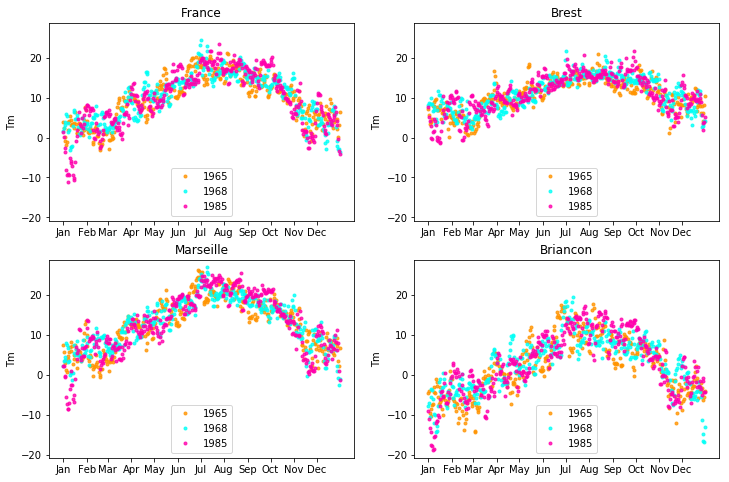

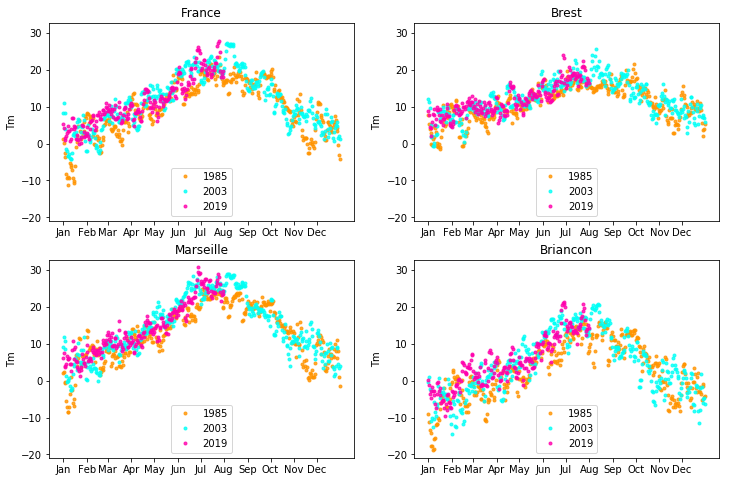

In [10]:
#########################
## Utiliser cette cellule
fig,axes = fig_time_series( dX , [1965,1968,1985] )
fig,axes = fig_time_series( dX , [1985,2003,2019] )
plt.show()
##
#########################

## III. Normales
### III.1 Contexte

Le but de cette section est de répondre à la question suivante: ***qu'est ce qu'une température normale?***. De manière plus précise, on donnera un sens à des phrases du type:
- Nous sommes 2 degrés au dessus des normales
- Nous sommes localement au dessus des normales, mais en dessous de la normale par rapport à la France
- Nous sommes en dessous des normales aujourd'hui, mais il y a 50 ans nous aurions été au dessus des normales

Pour cela plusieurs méthodes pour calculer des normales vont être proposés. Les cellules ci dessous contiennent le code pour afficher les *normale* seules ou avec les séries temporelles les années choisies.

In [11]:
def fig_normale( normale , **kwargs ):
	
	"""
	Fonction qui permet d'afficher des normales
	
	Arguments
	---------
	normale : xarray.DataArray ou list de DataArray
		Tableau (ou liste de tableau) qui contient les valeurs "normales" pour une année
	
	label_normale: str ou list(str) (optionnel)
		Les labels pour chaque normales
	color_normale: str ou list(str) (optionnel)
		Les couleurs pour chaque normales
	
	Return
	------
	fig  : Une figure matplotlib
	axes : Une liste des axes où ont été ploté les données
	
	Exemples
	--------
	fig,ax = fig_normale( [norm_0,norm_1] )
	"""
	fig,axes,normale = _fig_normale( normale , **kwargs )
	axes = _add_fig_labels( normale[0] , axes ) ## Les labels des axes et titres
	return fig,axes

In [12]:
def fig_time_series_normale( dX , normale , years , **kwargs ):
	"""
	Fonction qui permet d'afficher la série dX les année years et les normales
	
	Arguments
	---------
	dX : xarray.DataArray
		La variable dX
	normale : xarray.DataArray ou list de DataArray
		Tableau (ou liste de tableau) qui contient les valeurs "normales" pour une année
	years : entier ou list d'entier
		La ou les années à afficher
	
	label_normale: str ou list(str) (optionnel)
		Les labels pour chaque normales
	color_normale: str ou list(str) (optionnel)
		Les couleurs pour chaque normales
	
	Return
	------
	fig  : Une figure matplotlib
	axes : Une liste des axes où ont été ploté les données
	
	Exemples
	--------
	fig,ax = fig_normale_one_year( dX , [norm_0,norm_1] , 1973 , label_normale = ["norm0","norm1"] , color_normale = ["black","grey"] )
	"""
	fig,axes,normale = _fig_normale( normale , **kwargs )
	
	if type(years) is not list:
		years = [years]
	
	for j,c in enumerate(dX.location):
		for year in years:
			dXy = dX.sel({"time":str(year)}).loc[:,c] ## On extrait l'année
			axes[j].plot( dXy , color = "blue" , linestyle = "" , marker = "." , alpha = 0.5  ) ## On affiche
		axes[j].legend( loc = "lower center" )
	
	axes = _add_fig_labels( dX , axes ) ## Les labels des axes et titres
	
	return fig,axes

### III.2 Première normale : moyenne de chaque jour
Nous allons définir notre première normale de la manière suivante:
- Restreindre le jeu de donnée à une période de 30 ans
- La normale de chaque jour sera la moyenne sur les 30 ans de chaque jour, i.e. la normale du 1er janvier sera la moyenne des 30 1er janvier, la normale du 02/01 la moyenne des 30 2 janvier, etc.

La fonction ci dessous `normale_mean_along_days` renvoie un tableau de normale par rapport au `dX` en entrée.

In [13]:
def normale_mean_along_days(dX):
	"""
	Calcul de la normale quotidienne en moyennant chaque jour, pour chaque série temporelle
	
	Exemple
	-------
	dX_51_80   = dX.sel( time = slice("1951","1980") ) ## Periode de 1951 à 1980
	norm_51_80 = normale_mean_along_days(dX_51_80)     ## Calcul de la normale
	fig_time_series_normale( dX , norm_51_80 , 1970 )     ## Affichage de dX en 1970 en anomalie
	plt.show()
	"""
	return dX.groupby("time.dayofyear").mean( dim = "time" ).rename( dayofyear = "time" )

***Questions***
1. Calculer les normales sur les périodes 1951-1980 et 1981-2010 et les afficher.
2. Quelles informations pouvez vous extraire de ces normales ?
3. Quel est le problème de cette méthode ?

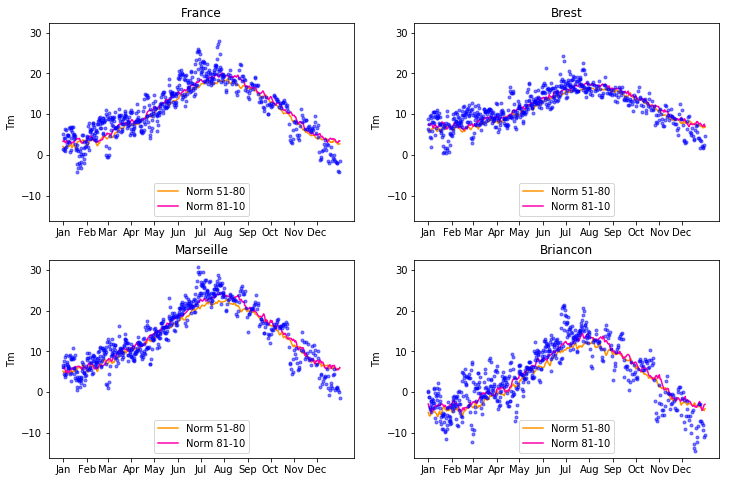

In [14]:
#########################
## Utiliser cette cellule

dX_51_80      = dX.sel( time = slice("1951","1980") ) ## Periode de 1951 à 1980
norm_51_80    = normale_mean_along_days(dX_51_80)     ## Calcul de la normale
dX_81_10      = dX.sel( time = slice("1981","2010") ) ## Periode de 1981 à 2010
norm_81_10    = normale_mean_along_days(dX_81_10)     ## Calcul de la normale
#fig_normale( [norm_51_80,norm_81_10] , label_normale = ["51-80","81-10"] )
fig_time_series_normale( dX , [norm_51_80,norm_81_10] , [1950,2019] , label_normale = ["Norm 51-80","Norm 81-10"])
plt.show()

##
#########################

### III.3 Lissage des normales
Le but de cette section est d'introduire une méthode de *lissage* des normales, afin d'avoir un signal plus régulier. La méthode choisi est celle d'un lissage *par noyau*. L'idée est la suivante, si on a une série temporelle $x_i\in\mathbb R$, on va fixer une taille de fenêtre (disons 3 ici), et chaque $x_i$ va être remplacé par la moyenne des 3 valeurs voisines (i.e. lui même et les deux voisins):

$$ \tilde x_i = \frac{x_{i-1} + x_i + x_{i+1}}{3}$$

Généralisons un peu, et supposons que la taille de la fenêtre soit un entier $N$, nous aurions alors:

$$\tilde x_i = \frac{1}{N}\sum_{j=i-N/2}^{i+N/2} x_j$$

Dans ce cas, nous avons remplacé $x_i$ par la moyenne de ces $N$ voisins. Notons $K$ (pour *kernel*) le vecteur suivant de taille $N$:

$$K = (1/N,1N,...,1/N)$$

Nous avons alors:
- K est un vecteur de somme égale à $1$
- Les coefficients sont des *poids*, qui pondère la moyenne

À partir de cette idée, les poids $1/N$ peuvent être modifiés. Nous pourrions par exemple dire que $x_i$ est le plus *représentatif* de $\tilde x_i$, et que plus on "s'éloigne", plus le poids faiblit. Un noyau de ce type est le noyau *Gaussien*, donnée par la fonction $x\mapsto \exp(-x^2)$.

Dans la cellule suivante la fonction `smoothing_normale` vous permet de lisser les normales calculées ci-dessus.

In [15]:
def smoothing_normale( normale , size_box , kernel , **kwargs ):
	"""
	Fonction qui permet de lisser une normale
	
	Arguments
	---------
	normale : xarray.DataArray ou list de DataArray
		Tableau (ou liste de tableau) qui contient les valeurs "normales" pour une année
	size_box : entier
		La taille de la fenêtre de lissage
	kernel : str
		Choix du noyau : "uniform" ou "gauss"
	
	
	Return
	------
	smooth_normale : normale lissée
	
	Exemples
	--------
	## Lisse avec un noyau Gaussien en utilisant une fenêtre de 30 jours, i.e.
	## 15 jours avant / après.
	norm_51_80_smooth = smoothing_normale( norm_51_80 , 30 , "gauss" )
	"""
	return normale.reduce( _moving_average , dim = "time" , size_box = size_box , kernel = kernel , **kwargs )

#### Questions
1. Lisser les normales 1951-1980 et 1981-2010 avec un noyau uniforme et une fenêtre de 30 jours, les afficher
2. Faites de même avec un noyau Gaussien
3. Afficher sur la même figure différentes normales lissées avec des fenêtres de taille différentes. Que remarquez vous ? 
4. Afficher sur la même figure une normale lissée 1951-1980 et une normale lissée 1981-2010. Que remarquez vous ?

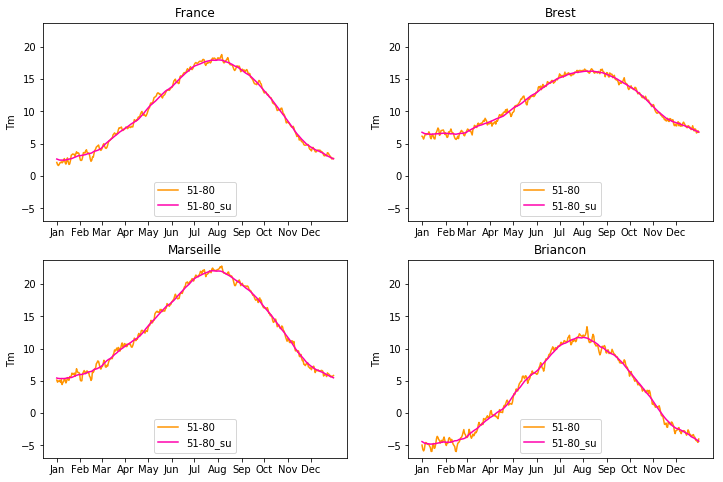

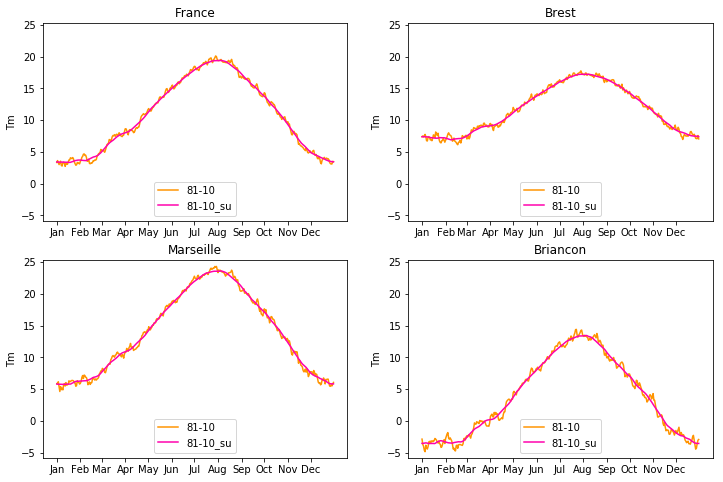

In [16]:
#########################
## Q1

norm_51_80_su = smoothing_normale( norm_51_80 , 30 , "uniform" )
norm_81_10_su = smoothing_normale( norm_81_10 , 30 , "uniform" )
fig_normale( [norm_51_80,norm_51_80_su] , label_normale = ["51-80","51-80_su"] )
fig_normale( [norm_81_10,norm_81_10_su] , label_normale = ["81-10","81-10_su"] )
plt.show()

##
#########################

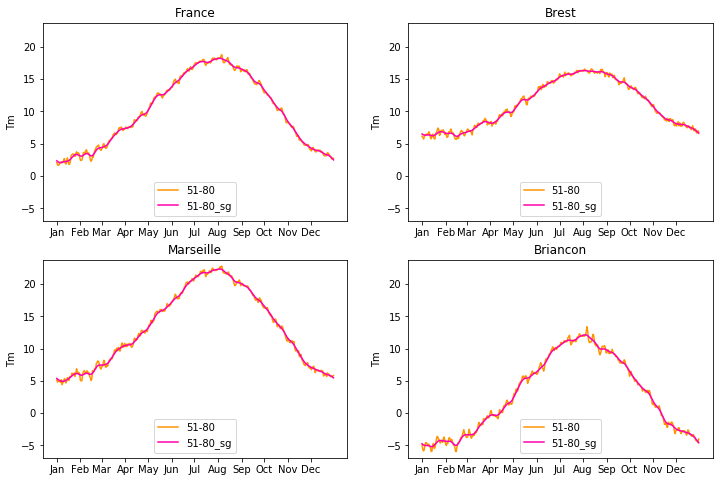

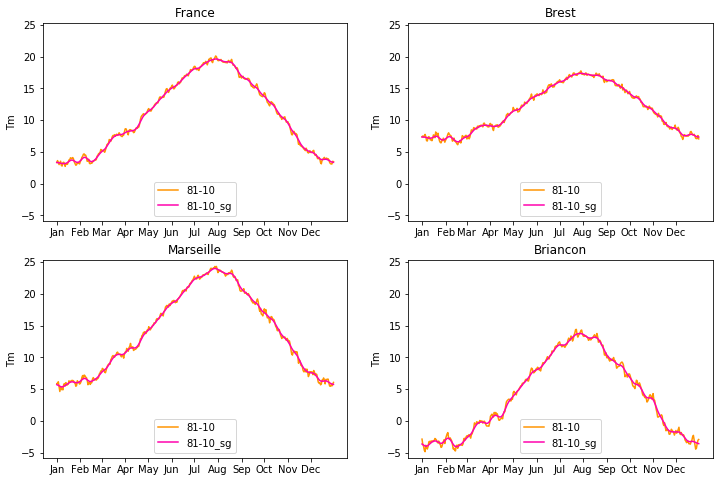

In [17]:
#########################
## Q2

norm_51_80_sg = smoothing_normale( norm_51_80 , 30 , "gauss" )
norm_81_10_sg = smoothing_normale( norm_81_10 , 30 , "gauss" )
fig_normale( [norm_51_80,norm_51_80_sg] , label_normale = ["51-80","51-80_sg"] )
fig_normale( [norm_81_10,norm_81_10_sg] , label_normale = ["81-10","81-10_sg"] )
plt.show()

##
#########################

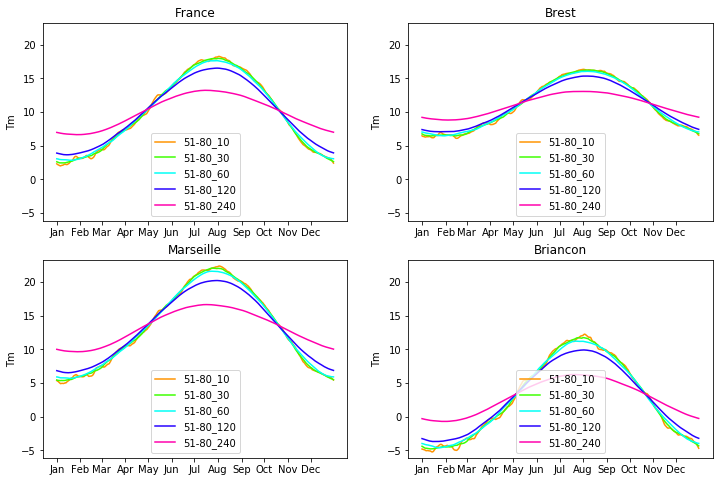

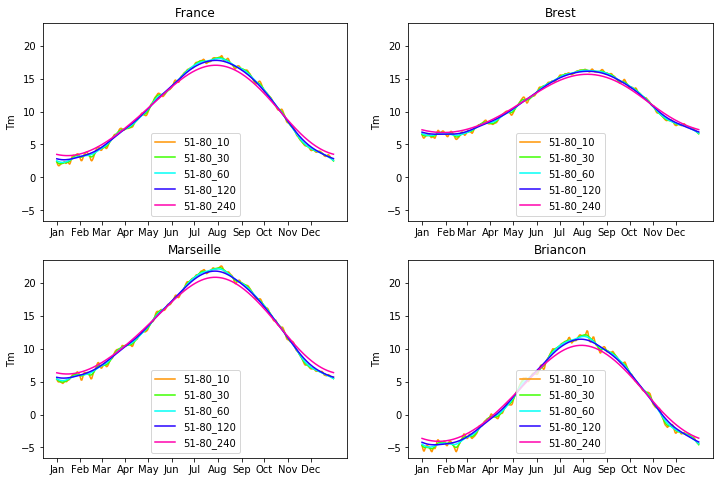

In [18]:
#########################
## Q3

lwindows = [10,30,60,120,240]

## Uniform
lnorms_51_80 = [smoothing_normale( norm_51_80 , size_box , "uniform" ) for size_box in lwindows ]
fig_normale( lnorms_51_80 , label_normale = ["51-80_{}".format(size_box) for size_box in lwindows ] )
plt.show()

## Gaussien
lnorms_51_80 = [smoothing_normale( norm_51_80 , size_box , "gauss" ) for size_box in lwindows ]
fig_normale( lnorms_51_80 , label_normale = ["51-80_{}".format(size_box) for size_box in lwindows ] )
plt.show()

##
#########################

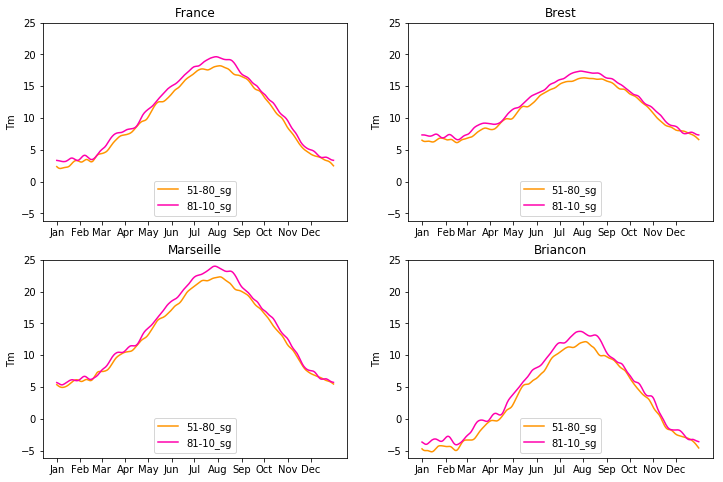

In [19]:
#########################
## Q3

fig_normale( [norm_51_80_sg,norm_81_10_sg] , label_normale = ["51-80_sg","81-10_sg"] )
plt.show()

##
#########################

### III.4 Regression linéaire en Fourier
Dans cette section nous allons voir une autre manière de construire des normales. L'idée est d'écrire que la série temporelle $x_i$ s'écrit chaque année:
$$x_i = \sum_{j=0}^H a_j \cos(\omega ij) + b_j \sin(\omega ij) + \varepsilon$$
Avec:
$$\omega = \frac{2\pi}{365}, \varepsilon\sim\mathcal{N}(0,\sigma)$$
Autrement dit, on décompose le signal en une somme de $H$ cosinus et sinus, plus un terme aléatoire gaussien $\varepsilon$. Les coefficients $a_j$ et $b_j$ seront calculés par une regression linéaire au sens des moindres carrées. La fonction `normale_fourier` de la cellule suivante calculera cette normale.

In [20]:
def normale_fourier( dX , H = 4 ):##{{{
	
	years  = np.unique( dX.time["time.year"] )
	n_year = years.size
	n_day  = int(dX.time.size / n_year)
	def _normale_fourier( X , axis , H ):
		## Design matrix
		omega = 2 * np.pi / n_day
		
		A = np.arange( 0,n_day,1).reshape(-1,1) @ np.arange(0,H,1).reshape(1,-1)
		A = np.hstack( (np.cos(omega*A),np.sin(omega*A)) )
		Ac = np.vstack( [A for _ in range(n_year)] )
		
		x = np.apply_along_axis( lambda z : scl.lstsq( Ac , z )[0] , axis , X )
		
		return Ac @ x
	
	return dX.reduce( _normale_fourier , dim = "time" , H = H ).sel({"time":"{}".format(years[0])}).assign_coords( time = range(1,n_day+1) )

***Questions***
1. Calculer les normales en Fourier 1951-1980 et 1981-2010 avec $H=4$ et les afficher.
2. Afficher pour chaque période sur le même graphe les normales par moyenne quotidiennes, lissées, en Fourier et les données en 2003

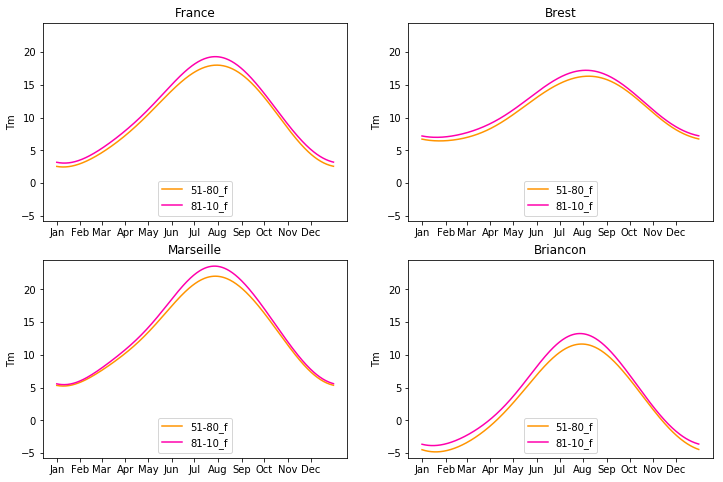

In [21]:
#########################
## Q1

norm_51_80_f = normale_fourier( dX_51_80 , 4 )
norm_81_10_f = normale_fourier( dX_81_10 , 4 )
fig_normale( [norm_51_80_f,norm_81_10_f] , label_normale = ["51-80_f","81-10_f"] )
plt.show()

##
#########################

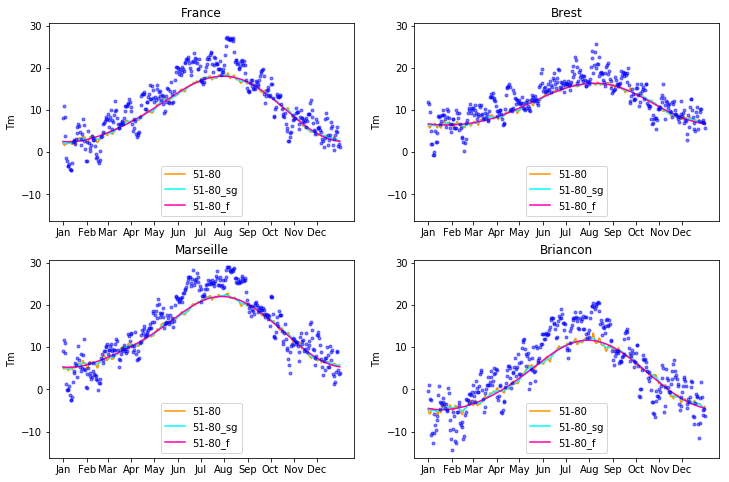

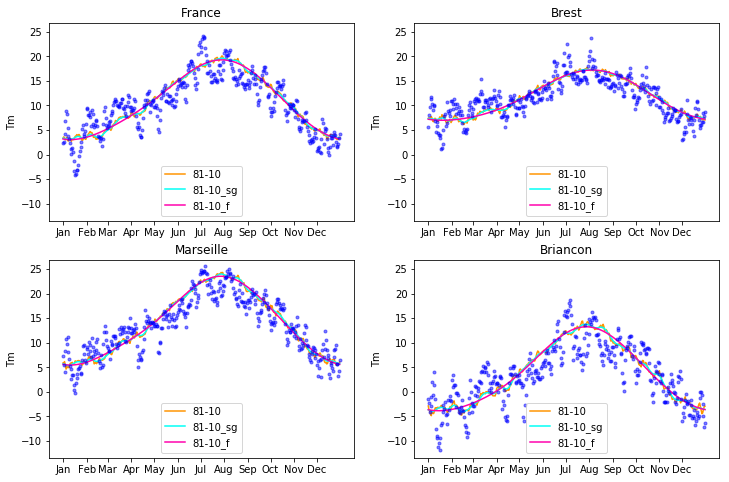

In [22]:
#########################
## Q2

lnorm_51_80   = [norm_51_80,norm_51_80_sg,norm_51_80_f]
llabels_51_80 = ["51-80","51-80_sg","51-80_f"]
fig_time_series_normale( dX , lnorm_51_80 , 2003 , label_normale = llabels_51_80 )

lnorm_81_10   = [norm_81_10,norm_81_10_sg,norm_81_10_f]
llabels_81_10 = ["81-10","81-10_sg","81-10_f"]
fig_time_series_normale( dX , lnorm_81_10 , 1957 , label_normale = llabels_81_10 )
plt.show()

##
#########################

## IV Densités climatiques
### IV.1 Première approche : les histogrammes
Le but de cette section est d'explorer une notion plus générale de normale, qui permet d'introduire le climat. *(Question: connaissez vous la différence météo/climat?)*. Nous allons d'abord découper notre jeu de données selon les saisons:

In [23]:
def cut_season(dX):
	"""
	Fonction pour découper dX en 4 DataArray selon les saisons:
	dX_w  : Winter
	dX_s  : Summer
	dX_f  : Fall (or Autumn)
	dX_sp : Spring
	"""
	(_,dX_w),(_,dX_s),(_,dX_f),(_,dX_sp) = dX.sel(time = slice("1950","2018") ).groupby("time.season")
	return dX_w,dX_s,dX_f,dX_sp

dX_w,dX_s,dX_f,dX_sp = cut_season(dX)

Plutot que de s'interesser à une variable moyenne (comme par exemple la moyenne de l'hiver), nous allons regarder *combien de fois* se produit un évènement en particulier. Par exemple, combien de fois les températures ont été comprises entre $0$ et $0.5$ degré en hiver? Ceci peut se visualiser facilement à l'aide d'un histogramme:

In [24]:
def fig_histogram( ldX , labels = None , dT = 0.5 ):
	"""
	Fonction pour afficher des histogrammes
	
	Arguments
	---------
	ldX : xarray.DataArray ou list(xarray.DataArray)
		La ou les variables dont on veut afficher les histogrammes
	labels : str ou list(str)
		Les noms à afficher de chaque variable
	dT : float
		Taille du bin (de l'intervalle entre deux températures) pour construire l'histogramme.
	"""
	fig,axes,_,_,_ = _fig_histogram( ldX , labels , dT , False )
	return fig,axes

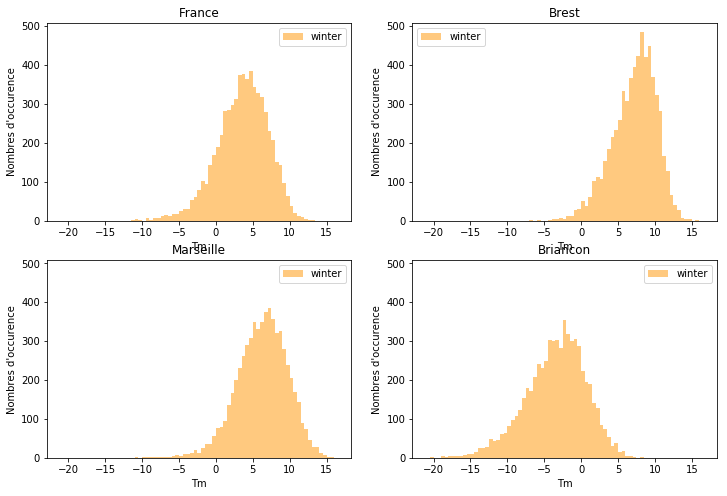

In [25]:
fig_histogram( dX_w , labels = "winter" )
plt.show()

Ces histogrammes montrent une structure très différentes en fonction de la zone considérées.

***Questions***
1. Décrire ces différentes répartition, pour l'hiver et l'été
2. Pour l'hiver et l'été, afficher les histogrammes pour la période 1951-1980 et la période 1981-2010 (rappel, on extrait une période avec la commande `dX_sous_per = dX.sel( time = slice("begin","end") )`). Que remarquez vous ?

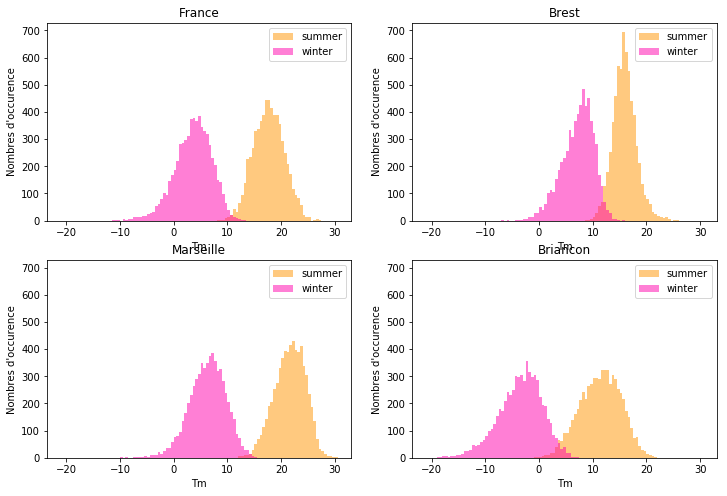

In [26]:
#########################
## Q1
fig_histogram( [dX_s,dX_w] , labels = ["summer","winter"] )
plt.show()
##
#########################

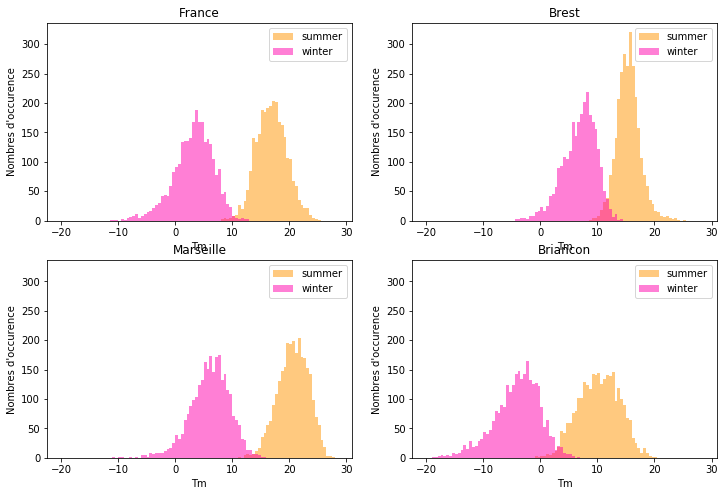

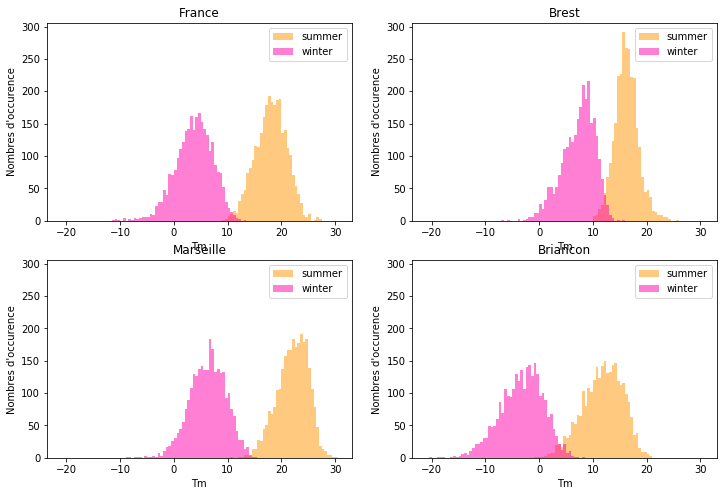

In [27]:
#########################
## Q2

fig_histogram( [ T.sel( time = slice("1951","1980") ) for T in [dX_s,dX_w] ] , labels = ["summer","winter"] )
fig_histogram( [ T.sel( time = slice("1981","2010") ) for T in [dX_s,dX_w] ] , labels = ["summer","winter"] )
plt.show()
##
#########################

### IV.2 Raffinement: les densités
L'un des problèmes des histogrammes est qu'ils peuvent être très irréguliers, et ils sont dépendant du pas `dT`. Les densités permettent de contourner ces problèmes. L'idée est que les densités décrivent la probabilité de chaque évènement. Mathématiquement, si $f$ désigne la densité cela s'écrit:

$$\mathbb{P}(T_m < T) = \int_{-\infty} ^T f(t).dt$$

Les histogrammes sont une approximation de cette densité $f$. Nous allons voir deux manières d'estimer $f$:

#### Hypothèse de Normalité
On suppose que $T_m\sim\mathcal{N}(\mu,\sigma)$, i.e. suit une loi normale (Gaussienne) de moyenne $\mu$ et d'écart type $\sigma$. Ces deux paramètres peuvent être estimée du jeu de donnée, et la densité s'écrit:
$$f(t)=\frac{1}{\sigma\sqrt{2\pi}} \exp\left( - \frac{1}{2} \left(\frac{t-\mu}{\sigma}\right)^2 \right)$$
La principale limitation de cette approche est qu'il n'y a pas forcément de raison *à priori* que les données suivent une loi normale.

#### Lissage par noyau
La deuxième méthode est analogue au lissage par noyau vue pour les normales ci-dessus. On obtient ainsi une description non-paramétrique de la densité.

La figure de la cellule suivante permet de représenter l'histogramme et les deux densités ci-dessus sur la même figure.

In [28]:
def fig_density( ldX , labels , dT = 0.5 ):
	"""
	Fonction pour afficher des histogrammes et des densités.
	La densité Gaussienne est en ligne pointillée, le lissage par noyau en ligne continue
	
	Arguments
	---------
	ldX : xarray.DataArray ou list(xarray.DataArray)
		La ou les variables dont on veut afficher les histogrammes et les densités
	labels : str ou list(str)
		Les noms à afficher de chaque variable
	dT : float
		Taille du bin (de l'intervalle entre deux températures) pour construire l'histogramme.
	"""
	fig,axes,Tm,ldX,colors = _fig_histogram( ldX , labels , dT , True , alpha = 0.3 )
	
	for i,dX in enumerate(ldX):
		for j,l in enumerate(dX.location):
			## Densité par noyau Gaussien
			dens = sc.gaussian_kde( dX.loc[:,l]).__call__(Tm)
			axes[j].plot( Tm , dens , color = colors[i] )
			
			## Densité par hypothèse Gaussienne
			pdf = sc.norm.pdf( Tm , loc = dX.loc[:,l].mean() , scale = dX.loc[:,l].std() )
			axes[j].plot( Tm , pdf , color = colors[i] , linestyle = "--" )
	
	return fig,axes

***Questions***
1. Afficher les densités pour l'hiver et l'été.
2. Afficher pour l'hiver et l'été les densités pour la période 1951-1980 et 1981-2010.
3. L'hypothèse de normalité est-elle justifiée?

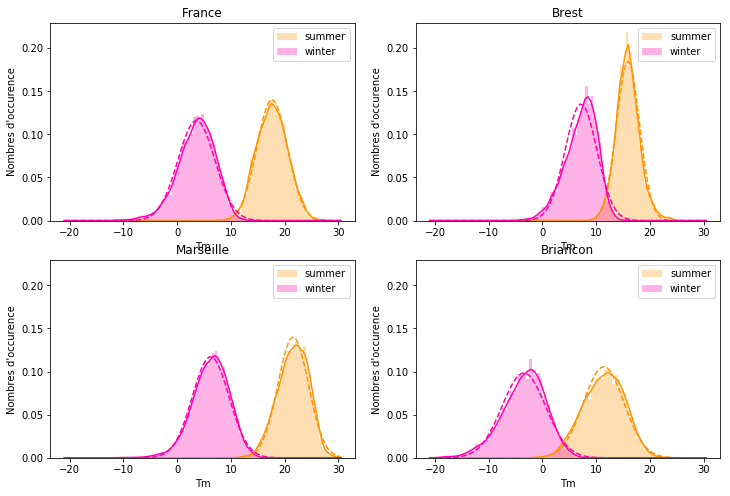

In [29]:
#########################
## Q1
fig_density( [dX_s,dX_w] , labels = ["summer","winter"])
plt.show()
##
#########################

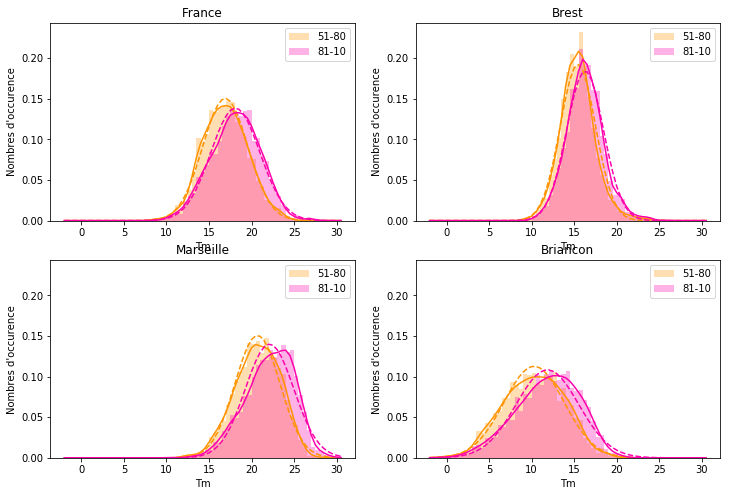

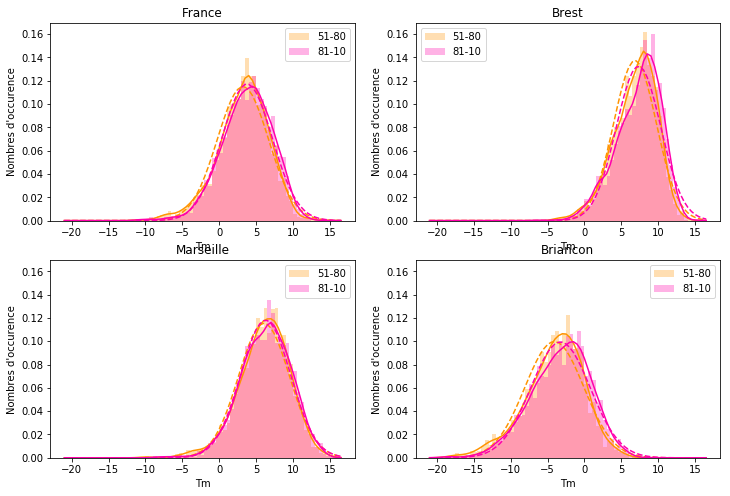

In [30]:
#########################
## Q2
T = dX_s
for T in [dX_s,dX_w]:
	fig_density( [T.sel( time = slice( "1951" , "1980" ) ) , T.sel( time = slice( "1981" , "2010" ) ) ] , labels = ["51-80","81-10"] )
plt.show()
##
#########################

## V. Extrêmes
Dans cette dernière partie, nous aborderons de manière succinte les extrêmes. Un évènement est dit *extrème* si la probabilité qu'il se réalise est "très faible". Par exemple, nous allons considérer les hivers (variable `dX_w`), et supposer qu'elle suit une loi normale. La classe suivante permet de simuler une loi Gaussienne:

In [31]:
class Gauss:
	def __init__( self , dX , mode = "max" ):
		self.loc   = dX.mean(dim = "time" ).values.squeeze()
		self.scale = dX.std( dim = "time" ).values.squeeze()
		self.law  = sc.norm.cdf if mode == "min" else sc.norm.sf
	
	def prob( self , event ):
		p = event.copy()
		for i,l in enumerate(event.location):
			p.loc[:,l] = self.law( event.loc[:,l] , loc = self.loc[i] , scale = self.scale[i] )
		return p

Construisons les variables suivantes:
- `g_51_80_w`: Une loi Gaussienne sur les hivers 1951-1980
- `g_81_10_w`: Une loi Gaussienne sur les hivers 1981-2010
- `dX_w_min` : les minimums de chaque hiver,

In [32]:
g_51_80_w = Gauss(dX_w.sel( time = slice("1951","1980" ) ) , mode = "min" ) ## Une loi Gaussienne sur les hivers 1951-1980
g_81_10_w = Gauss(dX_w.sel( time = slice("1981","2010" ) ) , mode = "min" ) ## Une loi Gaussienne sur les hivers 1981-2010
dX_w_min = dX_w.groupby("time.year").reduce( np.min , dim = "time" )        ## Les minimums de chaque hiver

Ce qui nous permet en appelant la fonction `prob` de la classe Gauss de calculer la probabilité pour chaque minimum que la température soit plus faible que le minimum donnée, i.e.:
$$\mathbb{P}(X < X_{min})$$
Ces valeurs sont stockées dans les variables suivantes:

In [33]:
p_51_80_w = g_51_80_w.prob(dX_w_min)
p_81_10_w = g_81_10_w.prob(dX_w_min)

Le script suivant affiche une figure avec `p_51_80_w` (en bleu) et `p_81_10_w` (en rouge).

/usr/lib64/python3.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


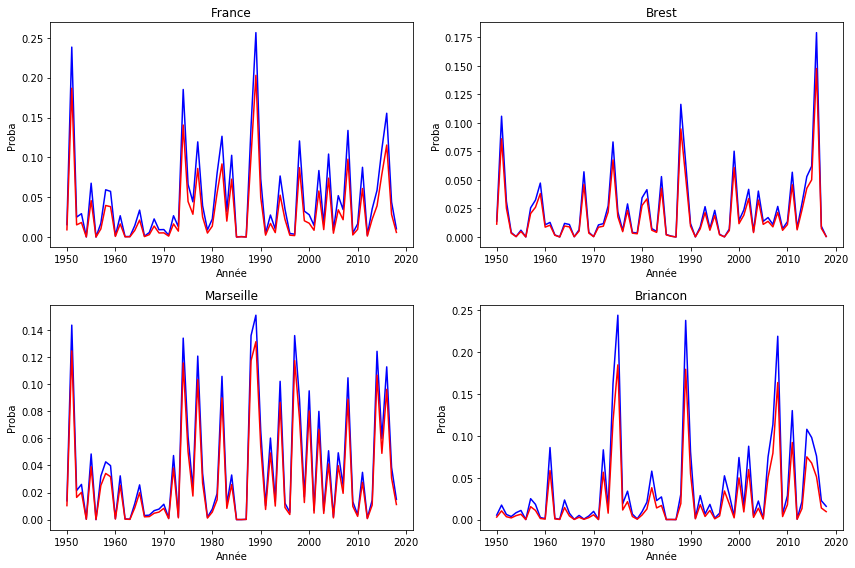

In [34]:
fig = plt.figure( figsize = (12,8) )
for i,l in enumerate(p_51_80_w.location):
	ax = fig.add_subplot( 2 , 2 , i + 1 )
	ax.plot( p_51_80_w.year , p_51_80_w.loc[:,l] , color = "blue" )
	ax.plot( p_81_10_w.year , p_81_10_w.loc[:,l] , color = "red"  )
	ax.set_xlabel("Année")
	ax.set_ylabel("Proba")
	ax.set_title(str(l.values))
fig.set_tight_layout(True)
plt.show()

Nous pouvons clairement voir que la probabilité de chaque minimum a diminué entre 1951 et 2010. Cette information peut se synthétiser au travers du *Probability Ratio*, notée PR, et égal à:
$$\mathrm{PR} = \frac{p_{81-10}}{p_{51-81}}$$
La figure suivante affiche $1/ \mathrm{PR}$ (par souci de lisibilité):

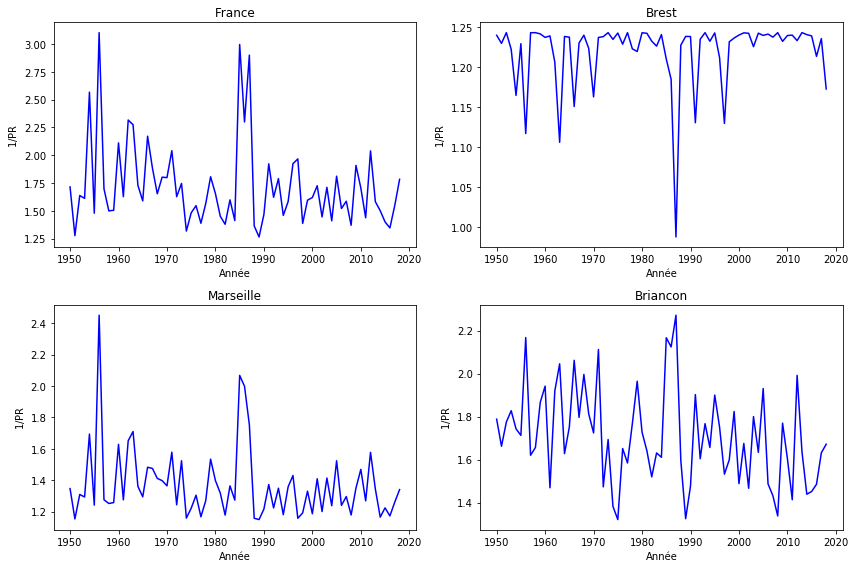

In [35]:
PR_w = p_81_10_w / p_51_80_w
fig = plt.figure( figsize = (12,8) )
for i,l in enumerate(p_51_80_w.location):
	ax = fig.add_subplot( 2 , 2 , i + 1 )
	ax.plot( PR_w.year , 1. / PR_w.loc[:,l] , color = "blue" )
	ax.set_xlabel("Année")
	ax.set_ylabel("1/$\mathrm{PR}$")
	ax.set_title(str(l.values))
fig.set_tight_layout(True)
plt.show()

En lisant ces graphes, on voit que les minimums déja passée sont devenus entre 1.25 et 3 fois moins probable sur la France, entre 1.2 et 2.4 fois moins probable sur Marseille, etc.

***Question***
En vous inspirant de ce protocole, éxaminez comment évoluent les maximums en été.
Aide:
- Il faudra utiliser la classe Gauss avec le mode "max"
- On a affiché 1/PR en hiver car les minimum deviennent *moins* probable, mais en été on peut estimer que les maximums vont devenir *plus* probable, et il faut donc afficher le PR.


In [36]:
g_51_80_s = Gauss(dX_s.sel( time = slice("1951","1980" ) ) , mode = "max" ) ## Une loi Gaussienne sur les étés 1951-1980
g_81_10_s = Gauss(dX_s.sel( time = slice("1981","2010" ) ) , mode = "max" ) ## Une loi Gaussienne sur les étés 1981-2010
dX_s_max = dX_s.groupby("time.year").reduce( np.max , dim = "time" )        ## Les maximums de chaque été

In [37]:
p_51_80_s = g_51_80_s.prob(dX_s_max)
p_81_10_s = g_81_10_s.prob(dX_s_max)
PR_s = p_81_10_s / p_51_80_s

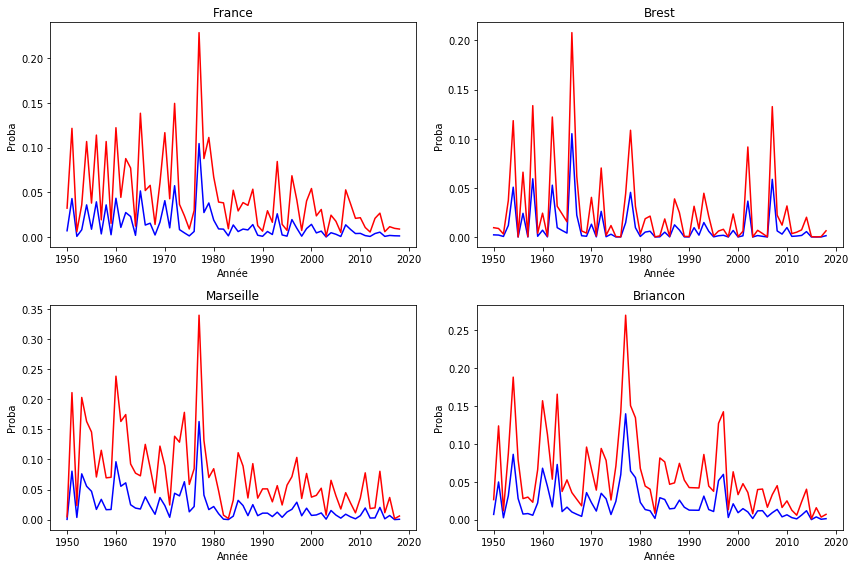

In [38]:
fig = plt.figure( figsize = (12,8) )
for i,l in enumerate(p_51_80_s.location):
	ax = fig.add_subplot( 2 , 2 , i + 1 )
	ax.plot( p_51_80_s.year , p_51_80_s.loc[:,l] , color = "blue" )
	ax.plot( p_81_10_s.year , p_81_10_s.loc[:,l] , color = "red"  )
	ax.set_xlabel("Année")
	ax.set_ylabel("Proba")
	ax.set_title(str(l.values))
fig.set_tight_layout(True)
plt.show()

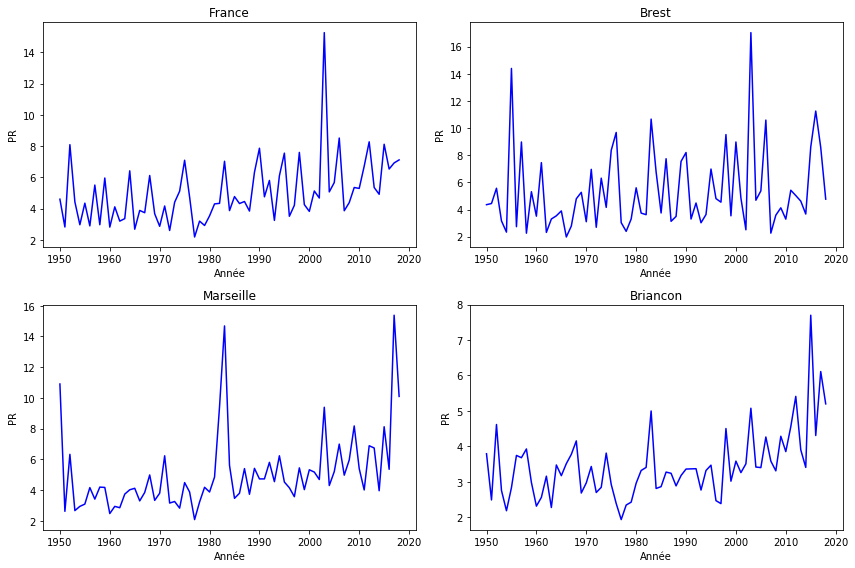

In [39]:
PR_s = p_81_10_s / p_51_80_s
fig = plt.figure( figsize = (12,8) )
for i,l in enumerate(p_51_80_s.location):
	ax = fig.add_subplot( 2 , 2 , i + 1 )
	ax.plot( PR_s.year , PR_s.loc[:,l] , color = "blue" )
	ax.set_xlabel("Année")
	ax.set_ylabel("$\mathrm{PR}$")
	ax.set_title(str(l.values))
fig.set_tight_layout(True)
plt.show()

## Conclusion

## VI Quelques bonus

### VI.1 Comparaison local / global
On se propose dans cette partie de comparer les normales locales aux normales globales. Pour ca, on va utiliser la fonction de la cellule suivante `keep_one_location` pour construire un tableau qui ne contiendra que la normale France, et on pourra comparer dans chaque ville la normale France et les autres normales.

In [40]:
def keep_one_location( normale , location ):
	"""
	Exemple
	-------
	dX_51_80      = dX.sel( time = slice("1951","1980") ) ## Periode de 1951 à 1980
	norm_51_80    = normale_mean_along_days(dX_51_80)     ## Calcul de la normale
	norm_51_80_fr = keep_one_location( norm_51_80 , "France" ) ## Ne garde que la normale de la France pour les 4 séries
	"""
	new_normale = normale.copy()
	for l in new_normale.location:
		new_normale.loc[:,l] = new_normale.loc[:,location]
	return new_normale

#### Questions
1. Utiliser la fonction `keep_one_location` pour construire des normales uniquement France sur la période 1951-1980 et 1981-2010
2. Afficher sur une même figure la normale France et les normales locales pour chaque période de temps
3. Quelles sont les différences entre Brest, Marseille et Briancon ? Avez vous une idée du pourquoi ?

In [41]:
#########################
## Q1

norm_51_80_fr = keep_one_location( norm_51_80_f , "France" )
norm_81_10_fr = keep_one_location( norm_81_10_f , "France" )

##
#########################

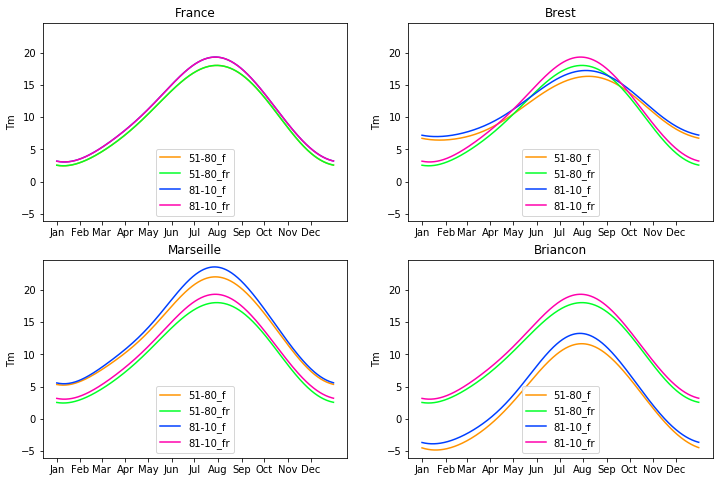

In [42]:
#########################
## Q2

fig_normale( [norm_51_80_f,norm_51_80_fr] + [norm_81_10_f,norm_81_10_fr] , label_normale = ["51-80_f","51-80_fr"] + ["81-10_f","81-10_fr"] )
plt.show()

##
#########################

### VI.2 Visualiser le changement climatique : les $\delta$ cycles

Les $\delta$ cycles sont une simple différences entre deux normales à deux périodes de temps différentes. Elles permettent en l'occurence de visualiser l'amplitude du changement climatique au cours de l'année.

#### Questions
1. Calculer les normales 1951-1980, 1961-1990, 1971-2000, 1981-2010 et 1989-2018 en Fourier
2. Calculer et afficher les $\delta$ cycles entre ces normales et la normale 1951-1980

In [43]:
#########################
## Q1

norm_51_80_f = normale_fourier( dX.sel( time = slice("1951","1980") ) )
norm_61_90_f = normale_fourier( dX.sel( time = slice("1961","1990") ) )
norm_71_00_f = normale_fourier( dX.sel( time = slice("1971","2000") ) )
norm_81_10_f = normale_fourier( dX.sel( time = slice("1981","2010") ) )
norm_89_18_f = normale_fourier( dX.sel( time = slice("1989","2018") ) )

##
#########################

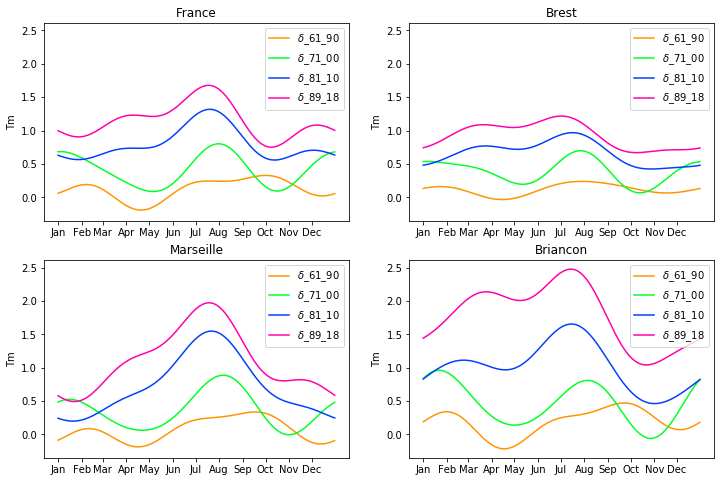

In [44]:
#########################
## Q2

delta_61_90 = norm_61_90_f - norm_51_80_f
delta_71_00 = norm_71_00_f - norm_51_80_f
delta_81_10 = norm_81_10_f - norm_51_80_f
delta_89_18 = norm_89_18_f - norm_51_80_f
l_delta = [delta_61_90,delta_71_00,delta_81_10,delta_89_18]
labels  = [r"$\delta$_61_90",r"$\delta$_71_00",r"$\delta$_81_10",r"$\delta$_89_18"]
fig_normale( l_delta , label_normale = labels , loc_legend = "upper right" )
plt.show()

##
#########################

### VI.3 Séries "à la Météo-France"
Nous allons finir cette section du TP en reproduisant une figure fournie par Météo-France, qui permet d'afficher une année donnée les relevés de températures en anomalies par rapport à une normale. Ceci sera fait par la fonction `fig_normale_anomalies` de la cellule suivante.

In [45]:
def fig_normale_anomalies( dX , normale , year , **kwargs ):
	"""
	Fonction qui permet d'afficher la série dX une année year en anomalie par rapport à la normale
	
	Arguments
	---------
	dX : xarray.DataArray
		La variable dX
	normale : xarray.DataArray ou list de DataArray
		Tableau (ou liste de tableau) qui contient les valeurs "normales" pour une année
	year : entier
		L'année à afficher
	
	label_normale: str ou list(str) (optionnel)
		Les labels pour chaque normales
	color_normale: str ou list(str) (optionnel)
		Les couleurs pour chaque normales
	
	Return
	------
	fig  : Une figure matplotlib
	axes : Une liste des axes où ont été ploté les données
	
	Exemples
	--------
	fig,ax = fig_normale_one_year( dX , [norm_0,norm_1] , 1973 , label_normale = ["norm0","norm1"] , color_normale = ["black","grey"] )
	"""
	fig,axes,normale = _fig_normale( normale , **kwargs )
	
	## Compute anomalies
	dXy = dX.sel({"time":str(year)}).assign_coords( time = range(1,366,1) )
	upper_fill = [dXy.where( dXy > n , n ) for n in normale] 
	lower_fill = [dXy.where( dXy < n , n ) for n in normale] 
	
	for j,c in enumerate(dX.location):
		for i in range(len(normale)):
			axes[j].fill_between( range(365) , normale[i].loc[:,c] , upper_fill[i].loc[:,c] , color = "red"  , alpha = 0.3 )
			axes[j].fill_between( range(365) , lower_fill[i].loc[:,c] , normale[i].loc[:,c] , color = "blue" , alpha = 0.3 )
		axes[j].legend( loc = "lower center" )
	
	axes = _add_fig_labels( dX , axes ) ## Les labels des axes et titres
	
	
	return fig,axes

#### Questions
1. Afficher en anomalie par rapport à la normale 1951-1980 l'année 2019
2. Afficher en anomalie par rapport à la normale 1981-2010 l'année 2019
3. Faites de même par rapport à la normale France en 2003
4. Amusez vous à changer les dates/normales

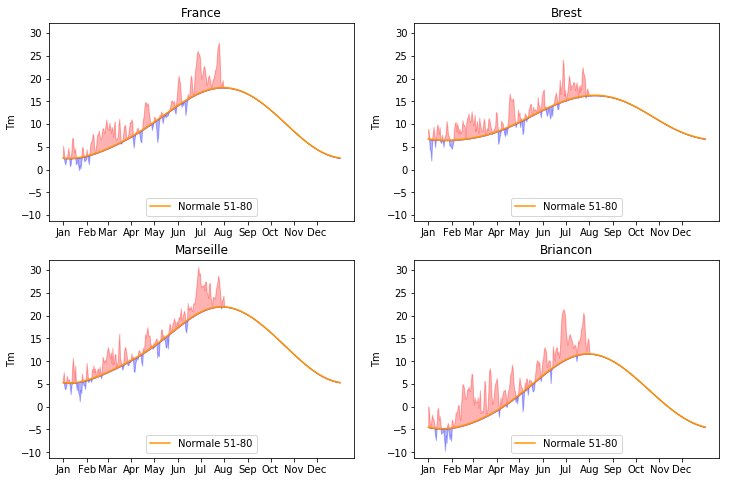

In [46]:
#########################
## Q1

fig_normale_anomalies( dX , norm_51_80_f , 2019 , label_normale = ["Normale 51-80"] )
plt.show()

##
#########################

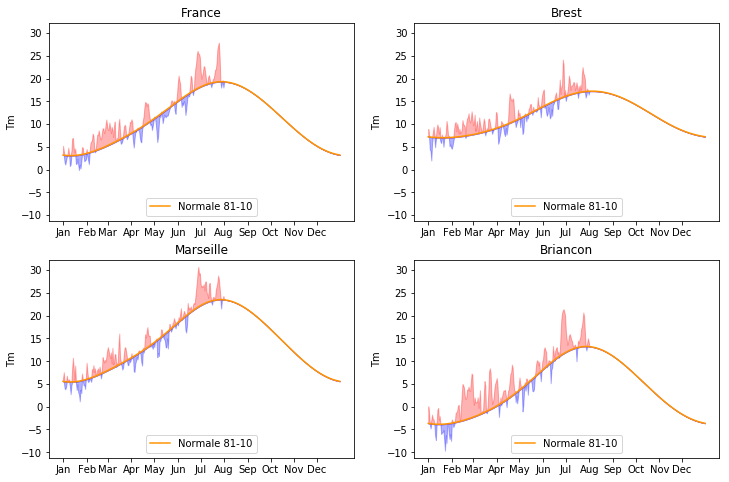

In [47]:
#########################
## Q2

fig_normale_anomalies( dX , norm_81_10_f , 2019 , label_normale = ["Normale 81-10"] )
plt.show()

##
#########################

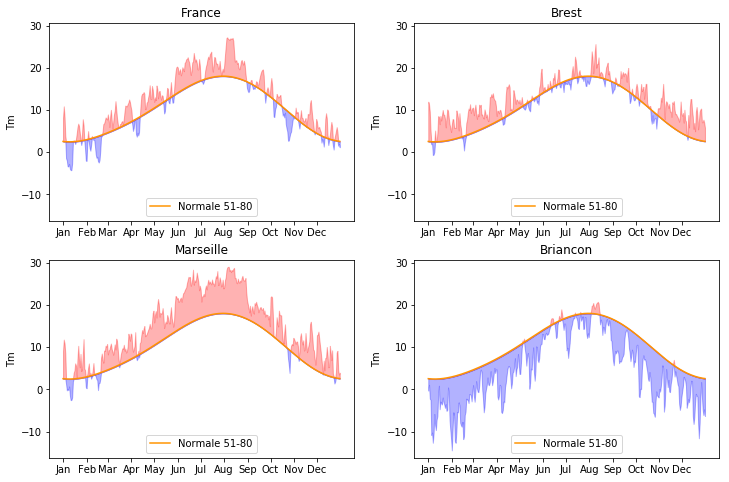

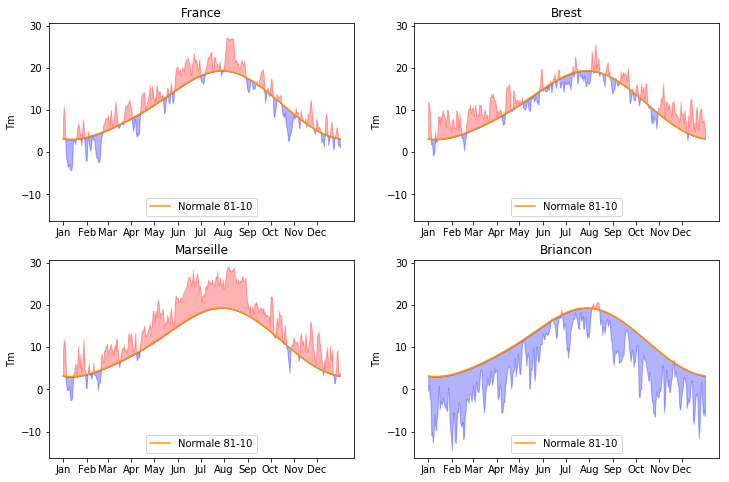

In [48]:
#########################
## Q3

fig_normale_anomalies( dX , norm_51_80_fr , 2003 , label_normale = ["Normale 51-80"] )
fig_normale_anomalies( dX , norm_81_10_fr , 2003 , label_normale = ["Normale 81-10"] )
plt.show()

##
#########################

In [49]:
#########################
## Q4

##
#########################